In [1]:
# Predict asteroid diameter values using 'Asteroid.csv' dataset from Kaggle contributed by Victor Basu
    # link: https://www.kaggle.com/basu369victor/prediction-of-asteroid-diameter
# Model: XGBRegressor
# Notes on data: 
    # data is medium size comprising of 839736 entries and 27 columns
    # for a small portion of the data (~ 1/6) the asteroids diameters are known - 
        # this portion will be used to train and validate the model
    # subsequently the model will be used to predict the diameters for the data in which this information is missing
    
# Essential updates (6/2020) from previous project version (2/2020)
    # Improvements in data processing and data visualization
    # Comparison between XGBRegressor model and Linear Regression model is discarded -->
        # XGBRegressor model optimization via hyperparameter tuning is added instead
    # Statistics of residuals - distribution, mean and standard deviation - replace absolute error statistics 
    # as model performance metrics

In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style = "whitegrid", font_scale = 1.5)

In [3]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read data

data = pd.read_csv('Asteroid.csv', low_memory = False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839736 entries, 0 to 839735
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   full_name       839736 non-null  object 
 1   a               839734 non-null  float64
 2   e               839736 non-null  float64
 3   G               119 non-null     float64
 4   i               839736 non-null  float64
 5   om              839736 non-null  float64
 6   w               839736 non-null  float64
 7   q               839736 non-null  float64
 8   ad              839730 non-null  float64
 9   per_y           839735 non-null  float64
 10  data_arc        823947 non-null  float64
 11  condition_code  838743 non-null  object 
 12  n_obs_used      839736 non-null  int64  
 13  H               837042 non-null  float64
 14  diameter        137681 non-null  object 
 15  extent          18 non-null      object 
 16  albedo          136452 non-null  float64
 17  rot_per   

In [5]:
# Print data column names for use in the code below

data.columns

Index(['full_name', 'a', 'e', 'G', 'i', 'om', 'w', 'q', 'ad', 'per_y',
       'data_arc', 'condition_code', 'n_obs_used', 'H', 'diameter', 'extent',
       'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'neo',
       'pha', 'moid'],
      dtype='object')

In [6]:
# Select only features with meaningful amount of non-null values --> 
    # drop 'G', 'extent', 'GM', 'BV', 'UB', 'IR', 'spec_B', and 'spec_T'
# In addition, drop 'full_name' and 'n_obs_used' which are not meaningful for the problem
# Place the target 'diameter' at the end for easier separation of features, X, and target, y, later on

data = data[['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code',
             'H', 'albedo', 'neo', 'pha', 'moid', 'diameter']]
data.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,albedo,neo,pha,moid,diameter
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,0,3.34,0.0900,N,N,1.594780,939.4
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,0,4.13,0.1010,N,N,1.233240,545
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,0,5.33,0.2140,N,N,1.034540,246.596
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,0,3.20,0.4228,N,N,1.139480,525.4
4,2.574249,0.191095,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431.0,0,6.85,0.2740,N,N,1.095890,106.699
5,2.425160,0.203007,14.737901,138.640203,239.807490,1.932835,2.917485,3.776755,62329.0,0,5.71,0.2679,N,N,0.973965,185.18
6,2.385334,0.231206,5.523651,259.563231,145.265106,1.833831,2.936837,3.684105,62452.0,0,5.51,0.2766,N,N,0.846100,199.83
7,2.201764,0.156499,5.886955,110.889330,285.287462,1.857190,2.546339,3.267115,62655.0,0,6.49,0.2260,N,N,0.874176,147.491
8,2.385637,0.123114,5.576816,68.908577,6.417369,2.091931,2.679342,3.684806,61821.0,0,6.28,0.1180,N,N,1.106910,190
9,3.141539,0.112461,3.831560,283.202167,312.315206,2.788240,3.494839,5.568291,62175.0,0,5.43,0.0717,N,N,1.778390,407.12


In [7]:
# 1) Data Processing and EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839736 entries, 0 to 839735
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               839734 non-null  float64
 1   e               839736 non-null  float64
 2   i               839736 non-null  float64
 3   om              839736 non-null  float64
 4   w               839736 non-null  float64
 5   q               839736 non-null  float64
 6   ad              839730 non-null  float64
 7   per_y           839735 non-null  float64
 8   data_arc        823947 non-null  float64
 9   condition_code  838743 non-null  object 
 10  H               837042 non-null  float64
 11  albedo          136452 non-null  float64
 12  neo             839730 non-null  object 
 13  pha             822814 non-null  object 
 14  moid            822814 non-null  float64
 15  diameter        137681 non-null  object 
dtypes: float64(12), object(4)
memory usage: 102.5+ MB


In [9]:
# Features 'condition_code', 'neo', and 'pha' appear to be categorical --> examine these features

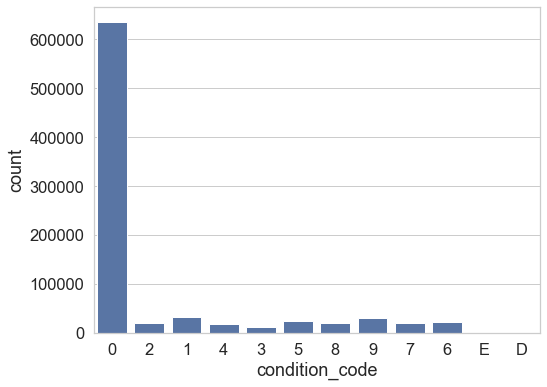

In [10]:
# Examine 'condition_code'

plt.figure(figsize = (8, 6))
sns.countplot(data['condition_code'], color = 'b')
plt.show()

In [11]:
# This is a categorical feature with majority of data points having values = 0
# Note that 'condition_code' values includes both numbers and letters

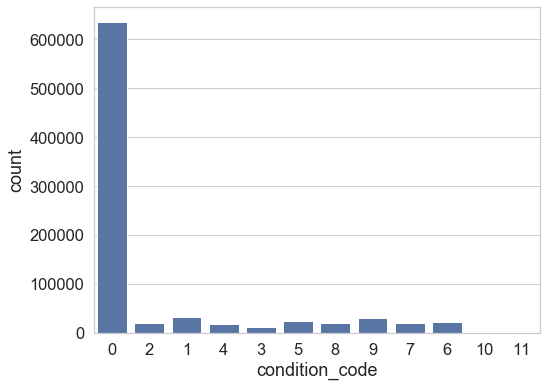

In [12]:
# Assign numeric values to the categorical values 'E' and 'D'

data['condition_code'].replace({'E': 10, 'D': 11}, inplace=True)

plt.figure(figsize = (8, 6))
sns.countplot(data['condition_code'], color = 'b')
plt.show()

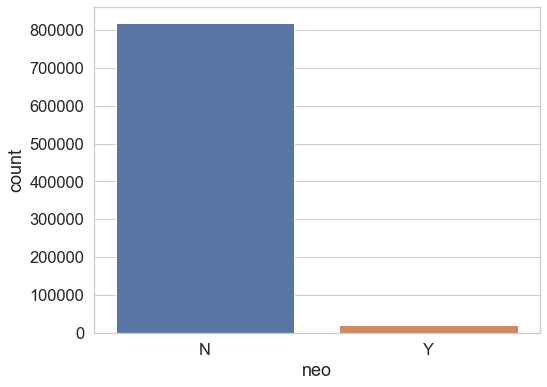

In [13]:
# Examine 'neo'

plt.figure(figsize = (8, 6))
sns.countplot(data['neo'])
plt.show()

In [14]:
# Categorical feature --> majority of data points = N

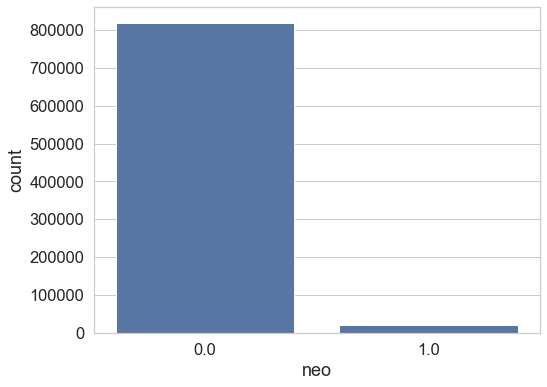

In [15]:
# Replace categorical values, N and Y, with numerical values of 0 and 1, respectively

data['neo'].replace({'N': 0, 'Y': 1}, inplace=True)

plt.figure(figsize = (8, 6))
sns.countplot(data['neo'], color = 'b')
plt.show()

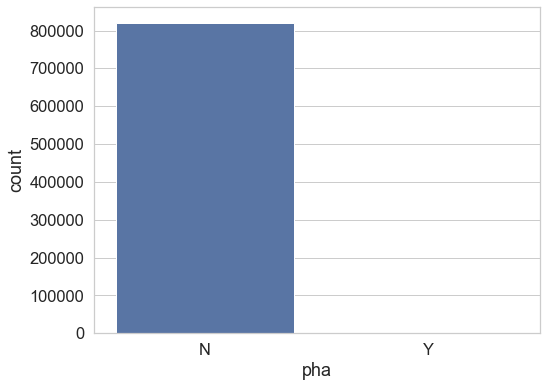

In [16]:
# Examine 'pha'

plt.figure(figsize = (8, 6))
sns.countplot(data['pha'])
plt.show()

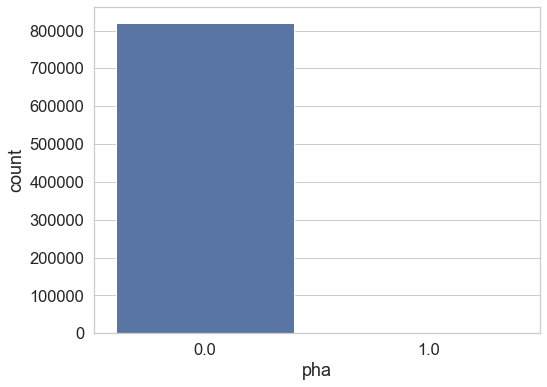

In [17]:
# Categorical feature --> majority of data points = N

# Replace the categorical values, N and Y, with numerical values of 0 and 1, respectively

data['pha'].replace({'N': 0, 'Y': 1}, inplace=True)

plt.figure(figsize = (8, 6))
sns.countplot(data['pha'], color = 'b')
plt.show()

In [18]:
# Examine target, 'diameter'

data.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,albedo,neo,pha,moid,diameter
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,0,3.34,0.0900,0.0,0.0,1.594780,939.4
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,0,4.13,0.1010,0.0,0.0,1.233240,545
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,0,5.33,0.2140,0.0,0.0,1.034540,246.596
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,0,3.20,0.4228,0.0,0.0,1.139480,525.4
4,2.574249,0.191095,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431.0,0,6.85,0.2740,0.0,0.0,1.095890,106.699
5,2.425160,0.203007,14.737901,138.640203,239.807490,1.932835,2.917485,3.776755,62329.0,0,5.71,0.2679,0.0,0.0,0.973965,185.18
6,2.385334,0.231206,5.523651,259.563231,145.265106,1.833831,2.936837,3.684105,62452.0,0,5.51,0.2766,0.0,0.0,0.846100,199.83
7,2.201764,0.156499,5.886955,110.889330,285.287462,1.857190,2.546339,3.267115,62655.0,0,6.49,0.2260,0.0,0.0,0.874176,147.491
8,2.385637,0.123114,5.576816,68.908577,6.417369,2.091931,2.679342,3.684806,61821.0,0,6.28,0.1180,0.0,0.0,1.106910,190
9,3.141539,0.112461,3.831560,283.202167,312.315206,2.788240,3.494839,5.568291,62175.0,0,5.43,0.0717,0.0,0.0,1.778390,407.12


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839736 entries, 0 to 839735
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               839734 non-null  float64
 1   e               839736 non-null  float64
 2   i               839736 non-null  float64
 3   om              839736 non-null  float64
 4   w               839736 non-null  float64
 5   q               839736 non-null  float64
 6   ad              839730 non-null  float64
 7   per_y           839735 non-null  float64
 8   data_arc        823947 non-null  float64
 9   condition_code  838743 non-null  object 
 10  H               837042 non-null  float64
 11  albedo          136452 non-null  float64
 12  neo             839730 non-null  float64
 13  pha             822814 non-null  float64
 14  moid            822814 non-null  float64
 15  diameter        137681 non-null  object 
dtypes: float64(14), object(2)
memory usage: 102.5+ MB


In [20]:
# Columns 'diameter' and 'albedo' have only about 1/6 of non-null values compared to other features
# Although 'diameter' has numerical values in the table, it appears that it is in string format - data type 'object'
# Convert data to numeric format 'float64'

data = data.astype('float64')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839736 entries, 0 to 839735
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               839734 non-null  float64
 1   e               839736 non-null  float64
 2   i               839736 non-null  float64
 3   om              839736 non-null  float64
 4   w               839736 non-null  float64
 5   q               839736 non-null  float64
 6   ad              839730 non-null  float64
 7   per_y           839735 non-null  float64
 8   data_arc        823947 non-null  float64
 9   condition_code  838743 non-null  float64
 10  H               837042 non-null  float64
 11  albedo          136452 non-null  float64
 12  neo             839730 non-null  float64
 13  pha             822814 non-null  float64
 14  moid            822814 non-null  float64
 15  diameter        137681 non-null  float64
dtypes: float64(16)
memory usage: 102.5 MB


In [21]:
# Replace all missing values with 0 which is the sparse value expected by XGBoost

data.fillna(0, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839736 entries, 0 to 839735
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               839736 non-null  float64
 1   e               839736 non-null  float64
 2   i               839736 non-null  float64
 3   om              839736 non-null  float64
 4   w               839736 non-null  float64
 5   q               839736 non-null  float64
 6   ad              839736 non-null  float64
 7   per_y           839736 non-null  float64
 8   data_arc        839736 non-null  float64
 9   condition_code  839736 non-null  float64
 10  H               839736 non-null  float64
 11  albedo          839736 non-null  float64
 12  neo             839736 non-null  float64
 13  pha             839736 non-null  float64
 14  moid            839736 non-null  float64
 15  diameter        839736 non-null  float64
dtypes: float64(16)
memory usage: 102.5 MB


In [22]:
# Create data set, data_1, where diameter is known

data_1 = data[data['diameter'] > 0] # values greater than 0 correspond to data with known diameter
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137681 entries, 0 to 810411
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               137681 non-null  float64
 1   e               137681 non-null  float64
 2   i               137681 non-null  float64
 3   om              137681 non-null  float64
 4   w               137681 non-null  float64
 5   q               137681 non-null  float64
 6   ad              137681 non-null  float64
 7   per_y           137681 non-null  float64
 8   data_arc        137681 non-null  float64
 9   condition_code  137681 non-null  float64
 10  H               137681 non-null  float64
 11  albedo          137681 non-null  float64
 12  neo             137681 non-null  float64
 13  pha             137681 non-null  float64
 14  moid            137681 non-null  float64
 15  diameter        137681 non-null  float64
dtypes: float64(16)
memory usage: 17.9 MB


In [23]:
# Data with known asteroid diameter have total of 137681 entries

In [24]:
# Check data_1

data_1.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,albedo,neo,pha,moid,diameter
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,0.0,3.34,0.0900,0.0,0.0,1.594780,939.400
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,0.0,4.13,0.1010,0.0,0.0,1.233240,545.000
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,0.0,5.33,0.2140,0.0,0.0,1.034540,246.596
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,0.0,3.20,0.4228,0.0,0.0,1.139480,525.400
4,2.574249,0.191095,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431.0,0.0,6.85,0.2740,0.0,0.0,1.095890,106.699
5,2.425160,0.203007,14.737901,138.640203,239.807490,1.932835,2.917485,3.776755,62329.0,0.0,5.71,0.2679,0.0,0.0,0.973965,185.180
6,2.385334,0.231206,5.523651,259.563231,145.265106,1.833831,2.936837,3.684105,62452.0,0.0,5.51,0.2766,0.0,0.0,0.846100,199.830
7,2.201764,0.156499,5.886955,110.889330,285.287462,1.857190,2.546339,3.267115,62655.0,0.0,6.49,0.2260,0.0,0.0,0.874176,147.491
8,2.385637,0.123114,5.576816,68.908577,6.417369,2.091931,2.679342,3.684806,61821.0,0.0,6.28,0.1180,0.0,0.0,1.106910,190.000
9,3.141539,0.112461,3.831560,283.202167,312.315206,2.788240,3.494839,5.568291,62175.0,0.0,5.43,0.0717,0.0,0.0,1.778390,407.120


In [25]:
# Everything looks fine

In [26]:
# Create dataset, data_2, where diameter is unknown

data_2 = data[data['diameter'] < data_1['diameter'].min()] # this leaves only 0s which correspond to unknown diameter
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702055 entries, 681 to 839735
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               702055 non-null  float64
 1   e               702055 non-null  float64
 2   i               702055 non-null  float64
 3   om              702055 non-null  float64
 4   w               702055 non-null  float64
 5   q               702055 non-null  float64
 6   ad              702055 non-null  float64
 7   per_y           702055 non-null  float64
 8   data_arc        702055 non-null  float64
 9   condition_code  702055 non-null  float64
 10  H               702055 non-null  float64
 11  albedo          702055 non-null  float64
 12  neo             702055 non-null  float64
 13  pha             702055 non-null  float64
 14  moid            702055 non-null  float64
 15  diameter        702055 non-null  float64
dtypes: float64(16)
memory usage: 91.1 MB


In [27]:
# Data with unknown asteroid diameter have total of 702055 entries (more than 5 x that of data_1)

In [28]:
# Check data_2

data_2.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,albedo,neo,pha,moid,diameter
681,2.654040,0.171983,11.505648,190.799958,104.993826,2.197591,3.110489,4.323837,40087.0,0.0,12.20,0.0,0.0,0.0,1.215450,0.0
698,2.610998,0.410284,15.299180,242.551766,91.399514,1.539746,3.682249,4.219081,42540.0,0.0,11.72,0.0,0.0,0.0,0.624487,0.0
718,2.638780,0.546301,11.564845,183.887287,156.163668,1.197212,4.080348,4.286601,39478.0,0.0,15.40,0.0,1.0,0.0,0.203359,0.0
729,2.243362,0.177505,4.234895,95.073806,123.549777,1.845154,2.641570,3.360139,39112.0,0.0,13.80,0.0,0.0,0.0,0.841461,0.0
842,2.279598,0.209766,7.997717,4.071363,316.957206,1.801415,2.757780,3.441878,37579.0,0.0,13.80,0.0,0.0,0.0,0.798230,0.0
961,2.908998,0.097329,2.602636,145.481660,223.473847,2.625868,3.192128,4.961619,37450.0,0.0,11.52,0.0,0.0,0.0,1.624760,0.0
984,2.299979,0.277462,4.056565,290.307048,59.553605,1.661822,2.938137,3.488142,35366.0,0.0,12.70,0.0,0.0,0.0,0.659274,0.0
1008,2.625175,0.455500,15.769676,229.461495,186.428747,1.429408,3.820942,4.253492,34990.0,0.0,13.90,0.0,0.0,0.0,0.441373,0.0
1010,2.391976,0.350864,5.494744,132.525452,353.279770,1.552718,3.231235,3.699504,34919.0,0.0,12.74,0.0,0.0,0.0,0.568578,0.0
1064,2.360276,0.297141,8.362855,330.324142,353.652287,1.658942,3.061610,3.626205,33882.0,0.0,12.10,0.0,0.0,0.0,0.646392,0.0


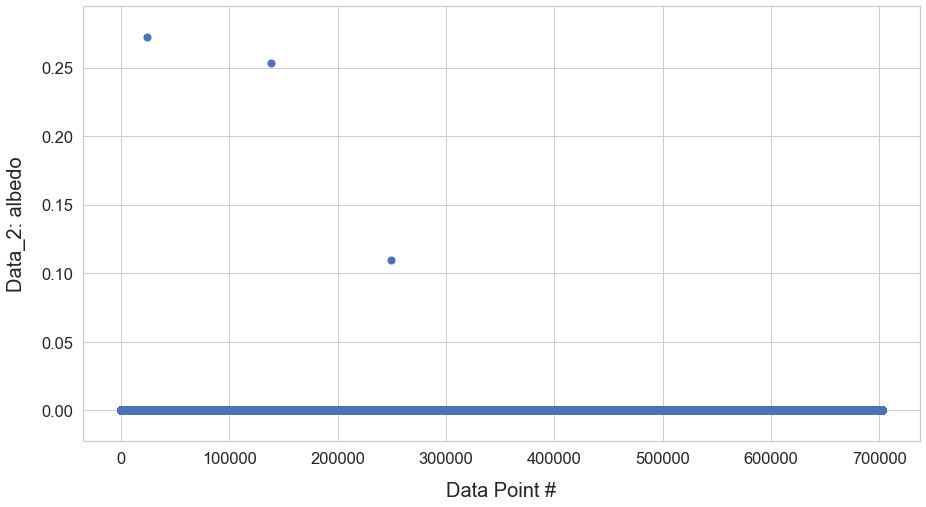

In [29]:
# It appears 'albedo' is also unknown in data_2 --> only 0s are shown in table

# Check by plotting data_2['albedo']

plt.figure(figsize = (15, 8))
plt.scatter(np.arange(1, len(data_2) + 1), data_2['albedo'], s = 50, c = 'b')
plt.xlabel('Data Point #', fontsize = 20, labelpad = 15)
plt.ylabel('Data_2: albedo', fontsize = 20, labelpad = 15)
plt.show()

In [30]:
# Indeed, almost all ‘albedo’ data points in data_2 are 0s and it cannot be used in predictions -->
    # remove ‘albedo’ from both data_1 and data_2

In [31]:
data_1.columns

Index(['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'H', 'albedo', 'neo', 'pha', 'moid', 'diameter'],
      dtype='object')

In [32]:
# Keep all features in data_1 except 'albedo'

data_1 = data_1[['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 
                 'condition_code', 'H', 'neo', 'pha', 'moid', 'diameter']]
data_1.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,neo,pha,moid,diameter
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,0.0,3.34,0.0,0.0,1.594780,939.400
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,0.0,4.13,0.0,0.0,1.233240,545.000
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,0.0,5.33,0.0,0.0,1.034540,246.596
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,0.0,3.20,0.0,0.0,1.139480,525.400
4,2.574249,0.191095,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431.0,0.0,6.85,0.0,0.0,1.095890,106.699
5,2.425160,0.203007,14.737901,138.640203,239.807490,1.932835,2.917485,3.776755,62329.0,0.0,5.71,0.0,0.0,0.973965,185.180
6,2.385334,0.231206,5.523651,259.563231,145.265106,1.833831,2.936837,3.684105,62452.0,0.0,5.51,0.0,0.0,0.846100,199.830
7,2.201764,0.156499,5.886955,110.889330,285.287462,1.857190,2.546339,3.267115,62655.0,0.0,6.49,0.0,0.0,0.874176,147.491
8,2.385637,0.123114,5.576816,68.908577,6.417369,2.091931,2.679342,3.684806,61821.0,0.0,6.28,0.0,0.0,1.106910,190.000
9,3.141539,0.112461,3.831560,283.202167,312.315206,2.788240,3.494839,5.568291,62175.0,0.0,5.43,0.0,0.0,1.778390,407.120


In [33]:
# Keep all features in data_2 except 'albedo' and 'diameter' which is unknown

data_2 = data_2[['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code', 'H', 'neo', 'pha', 'moid']]

data_2.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,neo,pha,moid
681,2.654040,0.171983,11.505648,190.799958,104.993826,2.197591,3.110489,4.323837,40087.0,0.0,12.20,0.0,0.0,1.215450
698,2.610998,0.410284,15.299180,242.551766,91.399514,1.539746,3.682249,4.219081,42540.0,0.0,11.72,0.0,0.0,0.624487
718,2.638780,0.546301,11.564845,183.887287,156.163668,1.197212,4.080348,4.286601,39478.0,0.0,15.40,1.0,0.0,0.203359
729,2.243362,0.177505,4.234895,95.073806,123.549777,1.845154,2.641570,3.360139,39112.0,0.0,13.80,0.0,0.0,0.841461
842,2.279598,0.209766,7.997717,4.071363,316.957206,1.801415,2.757780,3.441878,37579.0,0.0,13.80,0.0,0.0,0.798230
961,2.908998,0.097329,2.602636,145.481660,223.473847,2.625868,3.192128,4.961619,37450.0,0.0,11.52,0.0,0.0,1.624760
984,2.299979,0.277462,4.056565,290.307048,59.553605,1.661822,2.938137,3.488142,35366.0,0.0,12.70,0.0,0.0,0.659274
1008,2.625175,0.455500,15.769676,229.461495,186.428747,1.429408,3.820942,4.253492,34990.0,0.0,13.90,0.0,0.0,0.441373
1010,2.391976,0.350864,5.494744,132.525452,353.279770,1.552718,3.231235,3.699504,34919.0,0.0,12.74,0.0,0.0,0.568578
1064,2.360276,0.297141,8.362855,330.324142,353.652287,1.658942,3.061610,3.626205,33882.0,0.0,12.10,0.0,0.0,0.646392


In [34]:
# Data_1 has 14 features and target, 'diameter', left
# Data_2 consists of the same 14 features only -- no 'diameter'

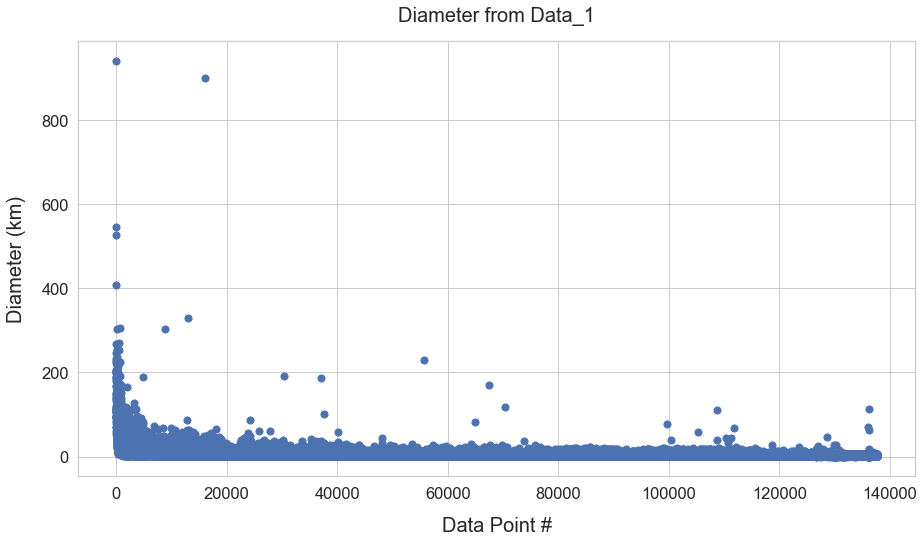

In [35]:
# Visualize 'diameter' from data_1 using scatterplot

plt.figure(figsize = (15, 8))
plt.scatter(np.arange(1, len(data_1) + 1), data_1['diameter'], s = 50, c = 'b')
plt.title('Diameter from Data_1', fontsize = 20, pad = 20)
plt.xlabel('Data Point #', fontsize = 20, labelpad = 15)
plt.ylabel('Diameter (km)', fontsize = 20, labelpad = 15)
plt.show()

In [36]:
# It appears 'diameter' has great number of small values and only small portion of large values
# Get some insights from min, max, median and mean of diameter in data_1

In [37]:
# Min, max, median and mean of diameter in data_1

print("Min diameter in km -->", round(data_1['diameter'].min(), 4))
print("Max diameter in km -->", round(data_1['diameter'].max(), 4))
print("Median diameter in km -->", round(data_1['diameter'].median(), 4))
print("Mean diameter in km -->", round(data_1['diameter'].mean(), 4))

Min diameter in km --> 0.0025
Max diameter in km --> 939.4
Median diameter in km --> 3.956
Mean diameter in km --> 5.4825


In [38]:
# Key observations:
    # 1) Max value is much larger than mean (almost 3 orders of magnitude)
    # 2) Despite that, mean and median are very close --> large values are small portion of the total number of observations

In [39]:
# Explore further by using boxplots
# Important note: 
    # use log scale due to large spread and disparity between the number of small (majority) and large diameter values

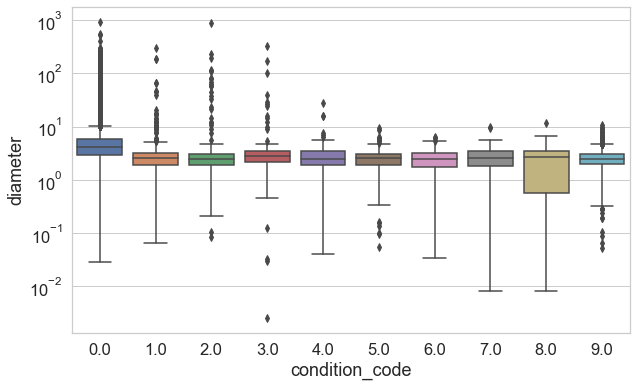

In [40]:
# Boxplot of 'diameter' in data_1 vs. 'condition_code' classes

plt.figure(figsize = (10, 6))
sns.boxplot(x = 'condition_code', y = 'diameter', data = data_1)
plt.yscale('log')
plt.show()

In [41]:
# Boxplot confirms that most of the diameter values are small -- between 0 and 10 km
# Everything above 10 km is considered outliers

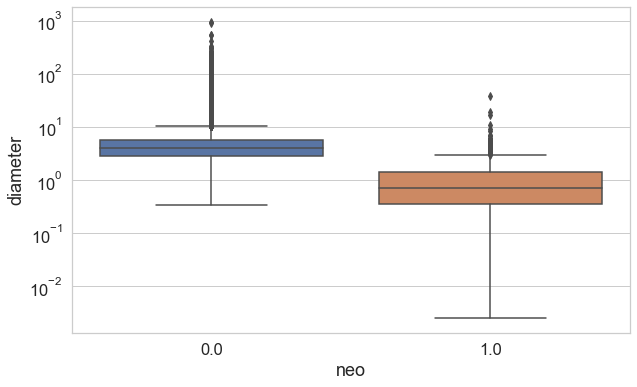

In [42]:
# Boxplot of 'diameter' in data_1 vs. 'neo' classes

plt.figure(figsize = (10, 6))
sns.boxplot(x = 'neo', y = 'diameter', data = data_1)
plt.yscale('log')
plt.show()

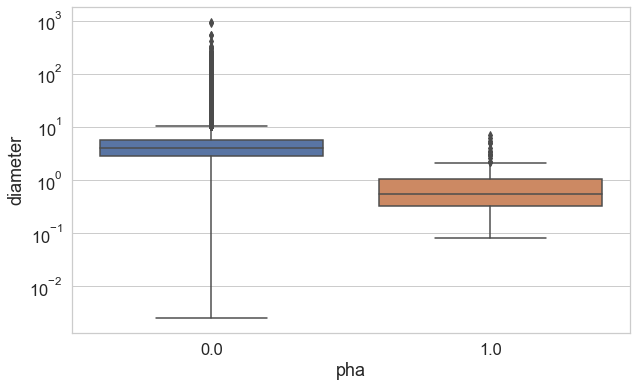

In [43]:
# Boxplot of 'diameter' in data_1 vs. 'pha' classes

plt.figure(figsize = (10, 6))
sns.boxplot(x = 'pha', y = 'diameter', data = data_1)
plt.yscale('log')
plt.show()

In [44]:
# The distribution of values by 'neo' and 'pha' classes is similar to that by 'condition_code' classes -->
    # Everything greater than 10 km is considered outlier

In [45]:
# This concludes Data Processing and EDA section

In [46]:
# 2) Apply XGBRegressor

In [47]:
# Separate features and target from data_1 which we will use with the xgb model

X_1 = data_1.iloc[:, :-1].values # all columns, but last
y_1 = data_1.iloc[:, -1].values # last column

X_2 = data_2.values # data_2 has only features

In [48]:
# Split X_1 and y_1 in train/test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size = 0.2, random_state = 0)

In [49]:
# Create XGBRegressor model

from xgboost import XGBRegressor

xgb_ini = XGBRegressor(objective = 'reg:squarederror') # denote model as'ini" to distinguish from optimized model later on

In [50]:
# Fit & predict

xgb_ini.fit(X_train, y_train)

y_pred_1a = xgb_ini.predict(X_test) # use indexing '_1a' for comparison with later predictions

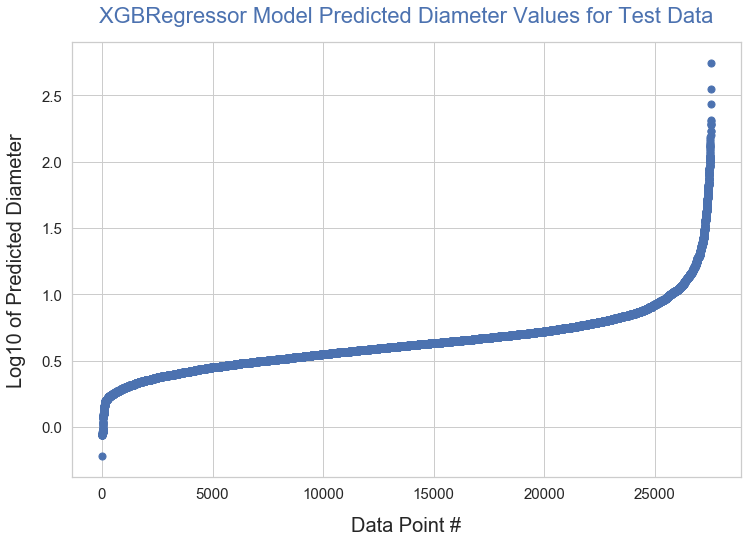

In [51]:
# Plot predicted diameter values in ascending order
# Log10 is used in order to display well all values

plt.figure(figsize = (12, 8))

plt.scatter(np.arange(1, len(y_test) + 1), np.sort(np.log10(y_pred_1a)), s = 50, color = 'b')

plt.xlabel('Data Point #', fontsize = 20, labelpad = 15)
plt.ylabel('Log10 of Predicted Diameter', fontsize = 20, labelpad = 15)
plt.title('XGBRegressor Model Predicted Diameter Values for Test Data', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.show()

In [52]:
# Main observations from plot
    # 1) small portion of predicted values are smaller than 1 km -- shown as negative values on the plot 
    # 2) largest value is approximately 500 km (10 ** 2.7)
    # 3) plot shows that vast majority of predicted values are less than 10 Km (10 ** 1)

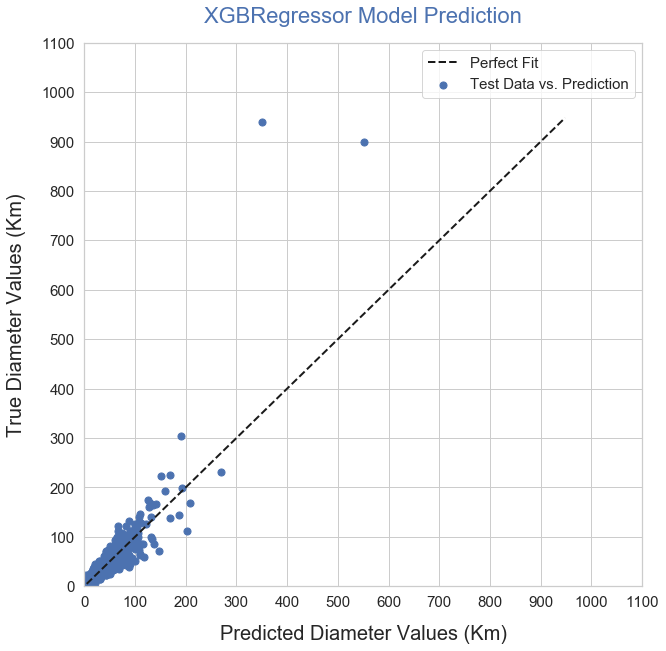

In [53]:
# Compare predictions, y_pred_1a, to test values, y_test, using scatterplot

# create line to represent perfect fit to y_test

y_line = np.arange(int(y_test.min()) - 10, int(y_test.max()) + 10)

# set axes limits - adjust if necessary
x_min = 0
x_max = y_test.max() + 100
d_x = 100

y_min = 0
y_max = y_test.max() + 100
d_y = 100

plt.figure(figsize = (10, 10))
ax = plt.axes()

ax.set_xlim(x_min, x_max)
ax.set_xticks(np.arange(x_min, x_max + d_x, d_x))

ax.set_ylim(y_min, y_max)
ax.set_yticks(np.arange(y_min, y_max + d_y, d_y))

plt.scatter(y_pred_1a, y_test, s = 50, c = 'b', label = 'Test Data vs. Prediction')
plt.plot(y_line, y_line, 'k--', lw = 2, label = 'Perfect Fit')
plt.xlabel('Predicted Diameter Values (Km)', fontsize = 20, labelpad = 15)
plt.ylabel('True Diameter Values (Km)', fontsize = 20, labelpad = 15)
plt.title('XGBRegressor Model Prediction', fontsize = 22, c = 'b', pad = 20)
plt.legend(fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

In [54]:
# Except for two "outliers", predictions are closely grouped around the perfect fit line
# Note: this will be discussed again later, but we would like to mention it here regarding the perceived "outliers".
    # Perhaps the only limitation of XGBoost is that its predictions are capped by the data used for training
    # From the scatter plot of all diameter values in the EDA secton and the current plot, 
    # it is clear that the training data contained only points with diameter smaller than 600 km.
    # That's why the predictions with the test data could not capture well the two points with diameter greater than 800 km

In [55]:
# Examine model predictions in a more quantitative way --> view statistics of residuals

In [56]:
# Get residuals

residuals_1a = y_test - y_pred_1a
residuals_1a

array([-0.91383727, -1.68171666, -0.20006578, ...,  0.16652586,
       -0.47324387,  0.01414502])

In [57]:
# Get residuals mean and standard deviation, sigma

print("Residuals_ini Mean:", round(residuals_1a.mean(),4))
print("Residuals_ini Sigma:", round(residuals_1a.std(),4))

Residuals_ini Mean: 0.0187
Residuals_ini Sigma: 4.9317


In [58]:
# Mean is close to zero and sigma is small compared to the test diameter values, y_test -->
    # indicates good model accuracy

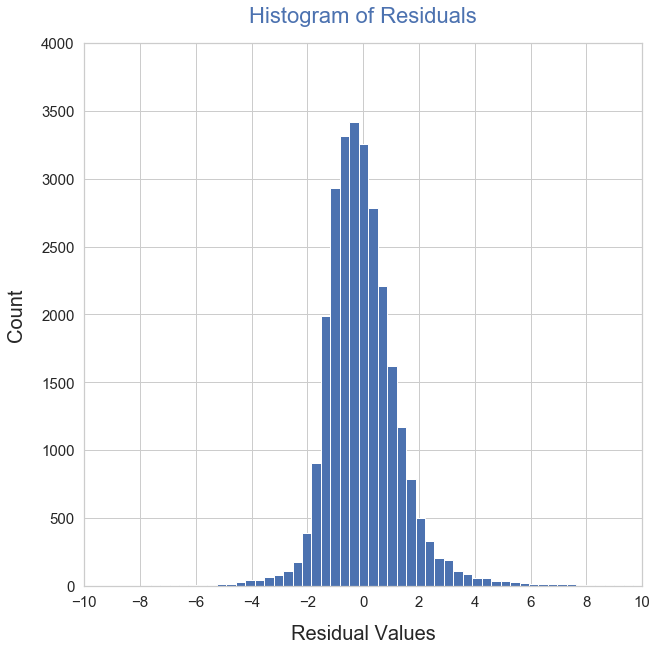

In [59]:
# Examine further: plot the histograms of the residuals --> 
    # for better visualization plot histogram only for values within two sigmas from the mean (~ 95% of all data points)

# Set axes limits - adjust if necessary
x_min = -10
x_max = 10
d_x = 2

y_min = 0
y_max = 4000
d_y = 500

plt.figure(figsize = (10, 10))
ax = plt.axes()

ax.set_xlim(x_min, x_max)
ax.set_xticks(np.arange(x_min, x_max + d_x, d_x))

ax.set_ylim(y_min, y_max)
ax.set_yticks(np.arange(y_min, y_max + d_y, d_y))

plt.hist(residuals_1a, bins = 2000, color = 'b')
plt.xlabel('Residual Values', fontsize = 20, labelpad = 15)
plt.ylabel('Count', fontsize = 20, labelpad = 15)
plt.title('Histogram of Residuals', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.show()

In [60]:
# Visually the histogram appears close to normal distribution -->
    # it is skewed slightly towards positive values which means that model is slightly underevaluating
    # this can also be seen from the scatter plot of y_test vs y_pred

In [61]:
# Predict the asteroid diameter values for the asteroids with unknown diameter, data_2, using model xgb_ini

y_pred_2a = xgb_ini.predict(X_2)

In [62]:
# Examine properties of predicted values by creating few simple plots

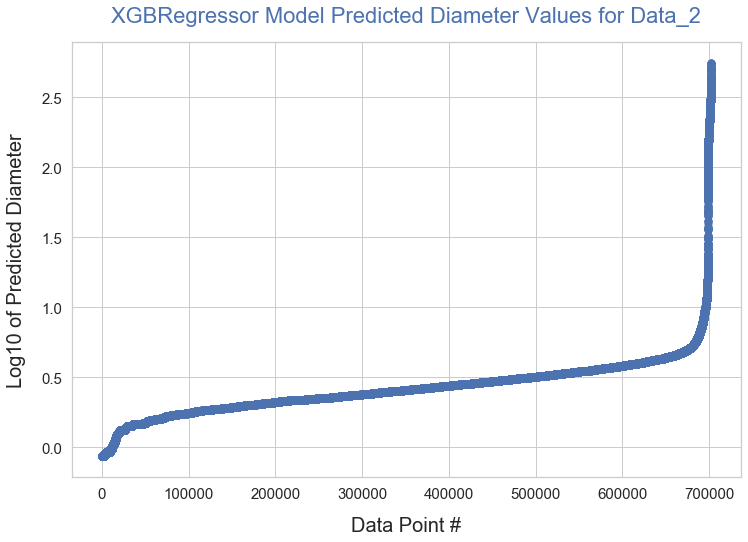

In [63]:
# Plot predicted diameter values in ascending order

# Log10 is used in order to display well all values

plt.figure(figsize = (12, 8))

plt.scatter(np.arange(1, len(X_2) +1), np.sort(np.log10(y_pred_2a)), s = 50, color = 'b')

plt.xlabel('Data Point #', fontsize = 20, labelpad = 15)
plt.ylabel('Log10 of Predicted Diameter', fontsize = 20, labelpad = 15)
plt.title('XGBRegressor Model Predicted Diameter Values for Data_2', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.show()

In [64]:
# The range of the predicted unknown diameter values is similar to that of the predicted test values

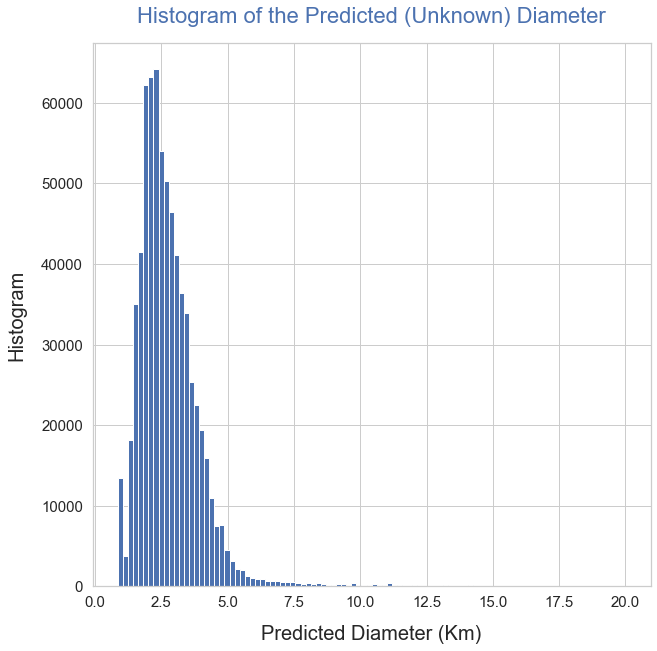

In [65]:
# Plot histogram of predicted diameter values
# For better visualization, limit histogram to diameter values smaller than 20 Km

plt.figure(figsize = (10, 10))

plt.hist(y_pred_2a[y_pred_2a < 20], bins = 100, color = 'b') # limit prediction values to 20 Km
plt.xlabel('Predicted Diameter (Km)', fontsize = 20, labelpad = 15)
plt.ylabel('Histogram', fontsize = 20, labelpad = 15)
plt.title('Histogram of the Predicted (Unknown) Diameter', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.show()

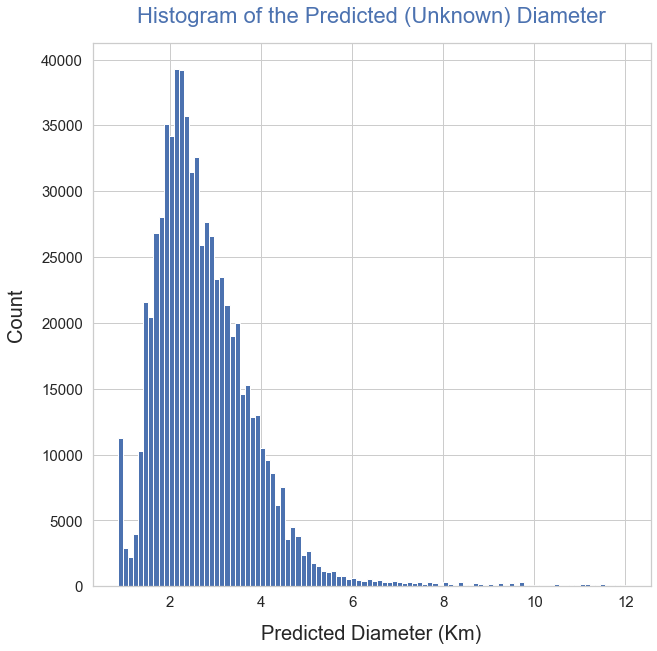

In [66]:
# Majority of predicted diameter values are capped by 12 km --> use this number as upper limit for histogram

plt.figure(figsize = (10, 10))

plt.hist(y_pred_2a[y_pred_2a < 12], bins = 100, color = 'b') # limit predicted values to 12 Km
plt.xlabel('Predicted Diameter (Km)', fontsize = 20, labelpad = 15)
plt.ylabel('Count', fontsize = 20, labelpad = 15)
plt.title('Histogram of the Predicted (Unknown) Diameter', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.show()

In [67]:
# Predicted values for unknown diameter (data_2) have Poisson-like distribution with most of the values between 1.5 and 4 km

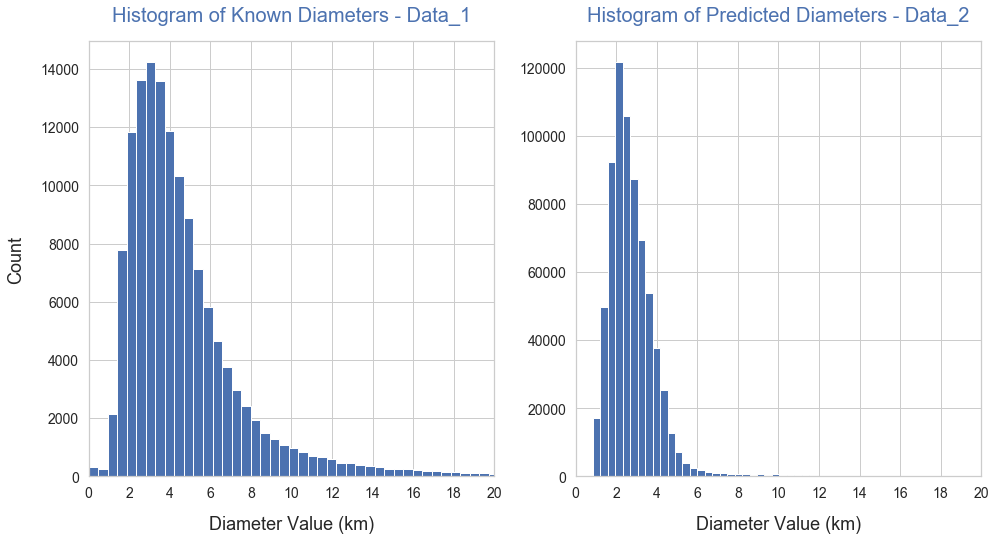

In [68]:
# Examine if distribution is similar to distribution of known diameter values --> 
    # for adequate comparison set x-axis limit to 20 km

# set axes limits - adjust if necessary
x_min = 0
x_max = 20
d_x = 2

fig, axes = plt.subplots(1, 2, sharey = False, figsize=(16,8))

# known diameter values
axes[0].hist(y_1, bins = 2000, color = 'b')
axes[0].set_title('Histogram of Known Diameters - Data_1', fontsize = 20, c = 'b', pad = 20)
axes[0].set_xlabel('Diameter Value (km)', fontsize = 18, labelpad = 15)
axes[0].set_ylabel('Count', fontsize = 18, labelpad = 15)
axes[0].set_xlim(x_min, x_max)
axes[0].set_xticks(np.arange(x_min, x_max + d_x, d_x))
axes[0].tick_params(labelsize = 14)


# predicted unknown diameter values
axes[1].hist(y_pred_2a, bins = 1500, color = 'b')
axes[1].set_title('Histogram of Predicted Diameters - Data_2', fontsize = 20, c = 'b', pad = 20)
axes[1].set_xlabel('Diameter Value (km)', fontsize = 18, labelpad = 15)
axes[1].set_xlim(x_min, x_max)
axes[1].set_xticks(np.arange(x_min, x_max + d_x, d_x))
axes[1].tick_params(labelsize = 14)

plt.show()

In [69]:
# It appears that predicted diameter values have significantly narrower distribution encompassing smaller values

# Couple of comments regarding this observation:

# 1) We do not know how the data with known and unknown asteroid diameter were collected -->
    # Thus, comparison between these two histograms may not be fully justified

# 2) However, assuming that the two sets of data are derived from the same astronomical observation and taking into account
# that the number of observation for asteroids with unknown diameter is ~ 5 times greater than that of known diameter
# one would expect that the predicted values should have similar or even wider distribution -->
    # Based on item #2, the question whether an optimized model would provide different results arises

In [70]:
# 3) Model optimization via hyperparameter tuning

In [71]:
# For tuning use 'max_depth', 'min_child_weight', 'gamma', 'n_estimators', 'learning_rate', and 'subsample' with Randomized Search

# Note: It is important to select appropriate ranges for each of these parameters

grid_random = {'max_depth': [3, 6, 10, 20],
              'min_child_weight': np.arange(1, 10, 1),
              'gamma': np.arange(0, 10, 1),
               'n_estimators': [50, 100, 150],
              'learning_rate': [0.001, 0.01, 0.1, 0.2],
              'subsample': np.arange(0.5, 1.0, 0.1)}

from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(objective = 'reg:squarederror')

xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = grid_random, n_iter = 100, cv = 5, verbose = 2, 
                                random_state = 42, n_jobs = -1)

In [72]:
# Fit xgb_random with X_train, y_train (using same data as with xgb_ini)

xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 38.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_...
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'gamma': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        

In [73]:
# Print best score and best model parameters

print("Best score: %f with %s" % (xgb_random.best_score_, xgb_random.best_params_))

Best score: 0.866256 with {'subsample': 0.8999999999999999, 'n_estimators': 100, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5}


In [74]:
# Get best_estimator_

xgb_opt = xgb_random.best_estimator_

In [75]:
# Use xgb_opt to predict for X_test data and compare with the true values, y_test

y_pred_1b = xgb_opt.predict(X_test)

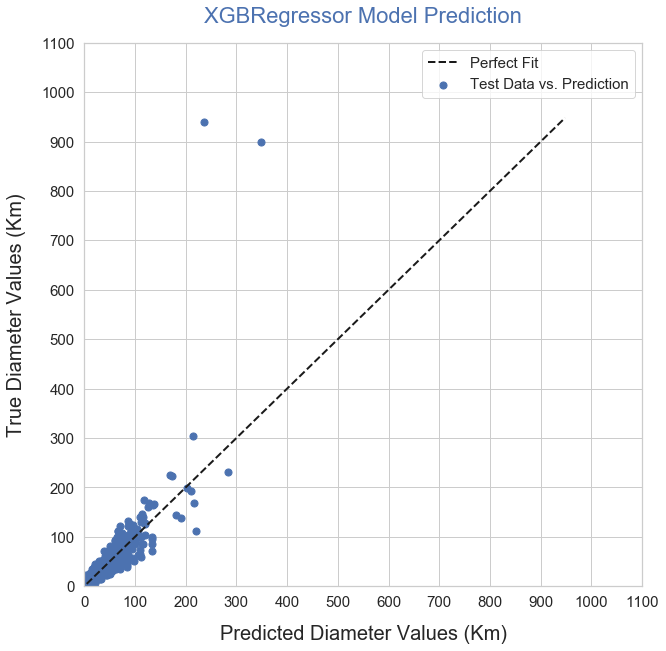

In [76]:
# Compare predictions, y_pred_1b, to test values, y_test

# create line to represent perfect fit to data test values, y_test

y_line = np.arange(int(y_test.min()) - 10, int(y_test.max()) + 10)

# set axes limits - adjust if necessary
x_min = 0
x_max = y_test.max() + 100
d_x = 100

y_min = 0
y_max = y_test.max() + 100
d_y = 100

plt.figure(figsize = (10, 10))
ax = plt.axes()

ax.set_xlim(x_min, x_max)
ax.set_xticks(np.arange(x_min, x_max + d_x, d_x))

ax.set_ylim(y_min, y_max)
ax.set_yticks(np.arange(y_min, y_max + d_y, d_y))

plt.scatter(y_pred_1b, y_test, s = 50, c = 'b', label = 'Test Data vs. Prediction')
plt.plot(y_line, y_line, 'k--', lw = 2, label = 'Perfect Fit')
plt.xlabel('Predicted Diameter Values (Km)', fontsize = 20, labelpad = 15)
plt.ylabel('True Diameter Values (Km)', fontsize = 20, labelpad = 15)
plt.title('XGBRegressor Model Prediction', fontsize = 22, c = 'b', pad = 20)
plt.legend(fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

In [77]:
# Predictions from  Optimized model have similar behavior to those from Initial model

In [78]:
# Get residuals

residuals_1b = y_test - y_pred_1b
residuals_1b

array([-1.05671079, -1.6761534 , -0.22539156, ...,  0.15230133,
       -0.62706057, -0.06124246])

In [79]:
# Compare residuals mean and standard deviation, sigma, from Initial and Optimized models

print("Residuals_ini Mean:", round(residuals_1a.mean(),4))
print("Residuals_ini Sigma:", round(residuals_1a.std(),4))
print('\n')
print("Residuals_opt Mean:", round(residuals_1b.mean(),4))
print("Residuals_opt Sigma:", round(residuals_1b.std(),4))

Residuals_ini Mean: 0.0187
Residuals_ini Sigma: 4.9317


Residuals_opt Mean: 0.0292
Residuals_opt Sigma: 6.0209


In [80]:
# Although numbers are close, Initial model has slightly better residuals mean and sigma
# Thus, we should consider changing the number of hyperparameter, their ranges and the optimization method used -->
    # Perhaps, use Bayesian optimization instead of Randomized Search
    # This goes beyond the scope of this project and will be explored in subsequent project

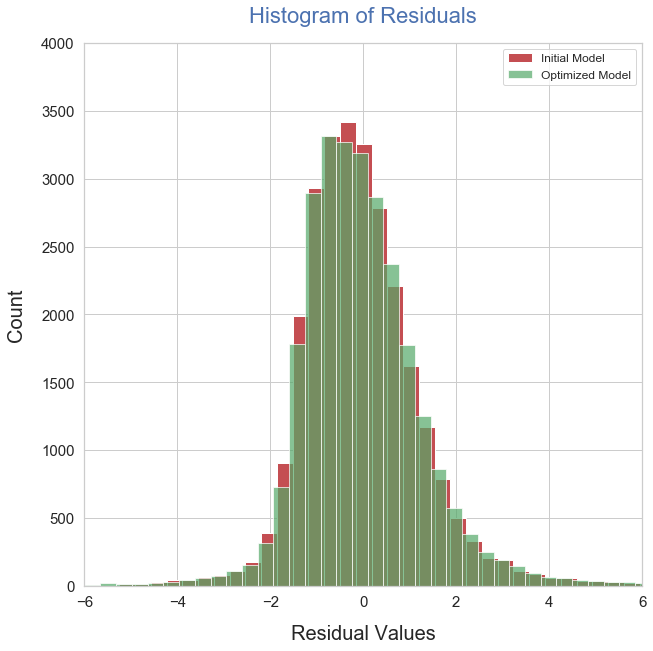

In [81]:
# Compare histograms of residuals from Initial and Optimized models --> for better comparison plot histograms on same graph

# Set axes limits - adjust if necessary
x_min = -6
x_max = 6
d_x = 2

y_min = 0
y_max = 4000
d_y = 500

plt.figure(figsize = (10, 10))
ax = plt.axes()

ax.set_xlim(x_min, x_max)
ax.set_xticks(np.arange(x_min, x_max + d_x, d_x))

ax.set_ylim(y_min, y_max)
ax.set_yticks(np.arange(y_min, y_max + d_y, d_y))

plt.hist(residuals_1a, bins = 2000, color = 'r', label = 'Initial Model')
plt.hist(residuals_1b, bins = 2400, color = 'g', alpha = 0.7, label = 'Optimized Model')
plt.xlabel('Residual Values', fontsize = 20, labelpad = 15)
plt.ylabel('Count', fontsize = 20, labelpad = 15)
plt.title('Histogram of Residuals', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 12)
plt.show()

In [82]:
# Histograms are nearly identical --> difficult to make the case for one model over the other

In [83]:
# Use xgb_opt to predict diameters for the set with unknown diameter, X_2

y_pred_2b = xgb_opt.predict(X_2)

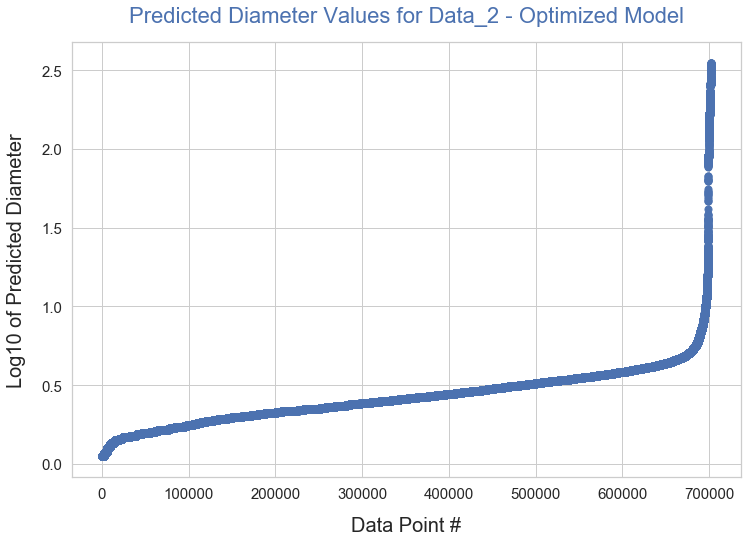

In [84]:
# Plot predicted diameter values in ascending order
# Log10 is used in order to display well all values

plt.figure(figsize = (12, 8))

plt.scatter(np.arange(1, len(X_2) +1), np.sort(np.log10(y_pred_2b)), s = 50, color = 'b')

plt.xlabel('Data Point #', fontsize = 20, labelpad = 15)
plt.ylabel('Log10 of Predicted Diameter', fontsize = 20, labelpad = 15)
plt.title('Predicted Diameter Values for Data_2 - Optimized Model', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.show()

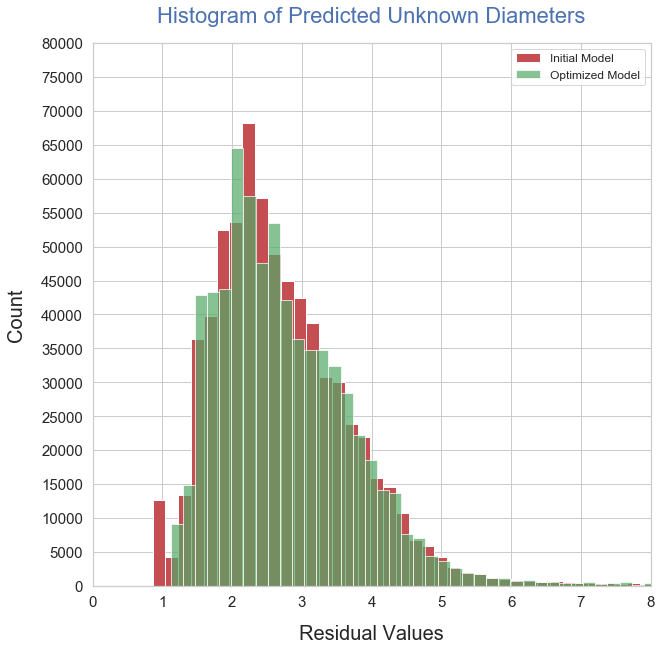

In [85]:
# Compare histograms of predicted diameters from Initial and Optimized models --> 
    # for better comparison plot histograms on same graph

# Set axes limits - adjust if necessary
x_min = 0
x_max = 8
d_x = 1

y_min = 0
y_max = 80000
d_y = 5000

plt.figure(figsize = (10, 10))
ax = plt.axes()

ax.set_xlim(x_min, x_max)
ax.set_xticks(np.arange(x_min, x_max + d_x, d_x))

ax.set_ylim(y_min, y_max)
ax.set_yticks(np.arange(y_min, y_max + d_y, d_y))

plt.hist(y_pred_2a, bins = 3000, color = 'r', label = 'Initial Model')
plt.hist(y_pred_2b, bins = 2000, color = 'g', alpha = 0.7, label = 'Optimized Model')
plt.xlabel('Residual Values', fontsize = 20, labelpad = 15)
plt.ylabel('Count', fontsize = 20, labelpad = 15)
plt.title('Histogram of Predicted Unknown Diameters', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 12)
plt.show()

In [86]:
# As with the residuals, the predicted unknown diameters distributions are nearly identical for both models
# Indicates that difference in distributions between known and predicted unknown diameters is not an issue of model optimization
# Because of the slightly better residual parameters we will use Initial model for final predictions

In [87]:
# 4) Final Predictions of Unknown Diameter

In [88]:
# Train Initial model with entire X_1, y_1 dataset and use that model to predict unknown diameters for X_2
# Reason: XGBoost predictions are capped by the training data and the max values might be missing there (as in our case)
# By using the entire 'data_1' dataset model should achieve the most accurate predictions possible

xgb_ini.fit(X_1, y_1)
y_pred_fin = xgb_ini.predict(X_2)

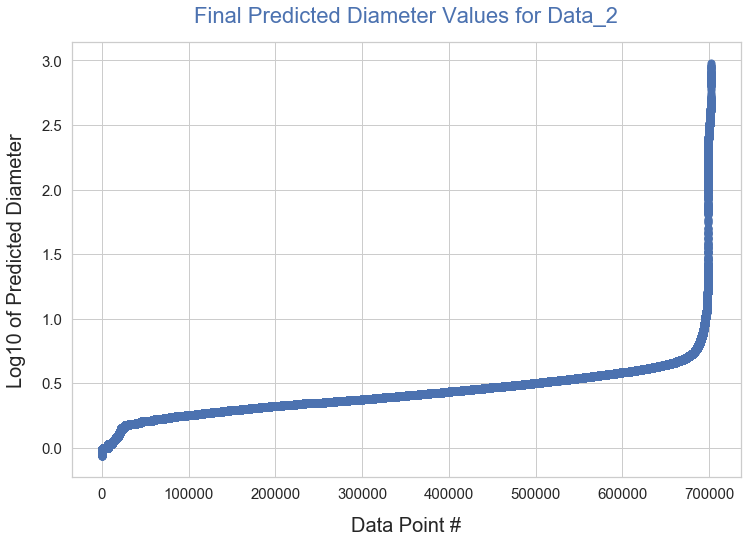

In [89]:
# Plot final predicted diameter values in ascending order
# Log10 is used in order to display well all values

plt.figure(figsize = (12, 8))

plt.scatter(np.arange(1, len(X_2) +1), np.sort(np.log10(y_pred_fin)), s = 50, color = 'b')

plt.xlabel('Data Point #', fontsize = 20, labelpad = 15)
plt.ylabel('Log10 of Predicted Diameter', fontsize = 20, labelpad = 15)
plt.title('Final Predicted Diameter Values for Data_2', fontsize = 22, c = 'b', pad = 20)
plt.tick_params(labelsize = 15)
plt.show()

In [90]:
# As expected, the maximum predicted value is now capped at 1000 km (10 ** 3)

In [91]:
# Finally, combine the predicted diameter values with features from data_2 to complete the data as our final delivarable

data_2.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,neo,pha,moid
681,2.654040,0.171983,11.505648,190.799958,104.993826,2.197591,3.110489,4.323837,40087.0,0.0,12.20,0.0,0.0,1.215450
698,2.610998,0.410284,15.299180,242.551766,91.399514,1.539746,3.682249,4.219081,42540.0,0.0,11.72,0.0,0.0,0.624487
718,2.638780,0.546301,11.564845,183.887287,156.163668,1.197212,4.080348,4.286601,39478.0,0.0,15.40,1.0,0.0,0.203359
729,2.243362,0.177505,4.234895,95.073806,123.549777,1.845154,2.641570,3.360139,39112.0,0.0,13.80,0.0,0.0,0.841461
842,2.279598,0.209766,7.997717,4.071363,316.957206,1.801415,2.757780,3.441878,37579.0,0.0,13.80,0.0,0.0,0.798230
961,2.908998,0.097329,2.602636,145.481660,223.473847,2.625868,3.192128,4.961619,37450.0,0.0,11.52,0.0,0.0,1.624760
984,2.299979,0.277462,4.056565,290.307048,59.553605,1.661822,2.938137,3.488142,35366.0,0.0,12.70,0.0,0.0,0.659274
1008,2.625175,0.455500,15.769676,229.461495,186.428747,1.429408,3.820942,4.253492,34990.0,0.0,13.90,0.0,0.0,0.441373
1010,2.391976,0.350864,5.494744,132.525452,353.279770,1.552718,3.231235,3.699504,34919.0,0.0,12.74,0.0,0.0,0.568578
1064,2.360276,0.297141,8.362855,330.324142,353.652287,1.658942,3.061610,3.626205,33882.0,0.0,12.10,0.0,0.0,0.646392


In [92]:
# Reset data_2 indices before adding the predicted diameter values

data_2 = data_2.reset_index(drop = True)

data_2.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,neo,pha,moid
0,2.654040,0.171983,11.505648,190.799958,104.993826,2.197591,3.110489,4.323837,40087.0,0.0,12.20,0.0,0.0,1.215450
1,2.610998,0.410284,15.299180,242.551766,91.399514,1.539746,3.682249,4.219081,42540.0,0.0,11.72,0.0,0.0,0.624487
2,2.638780,0.546301,11.564845,183.887287,156.163668,1.197212,4.080348,4.286601,39478.0,0.0,15.40,1.0,0.0,0.203359
3,2.243362,0.177505,4.234895,95.073806,123.549777,1.845154,2.641570,3.360139,39112.0,0.0,13.80,0.0,0.0,0.841461
4,2.279598,0.209766,7.997717,4.071363,316.957206,1.801415,2.757780,3.441878,37579.0,0.0,13.80,0.0,0.0,0.798230
5,2.908998,0.097329,2.602636,145.481660,223.473847,2.625868,3.192128,4.961619,37450.0,0.0,11.52,0.0,0.0,1.624760
6,2.299979,0.277462,4.056565,290.307048,59.553605,1.661822,2.938137,3.488142,35366.0,0.0,12.70,0.0,0.0,0.659274
7,2.625175,0.455500,15.769676,229.461495,186.428747,1.429408,3.820942,4.253492,34990.0,0.0,13.90,0.0,0.0,0.441373
8,2.391976,0.350864,5.494744,132.525452,353.279770,1.552718,3.231235,3.699504,34919.0,0.0,12.74,0.0,0.0,0.568578
9,2.360276,0.297141,8.362855,330.324142,353.652287,1.658942,3.061610,3.626205,33882.0,0.0,12.10,0.0,0.0,0.646392


In [93]:
# Transform y_pred_1b array into series with name 'diameter'

y_pred_fin = pd.Series(y_pred_fin, name = 'diameter')
y_pred_fin.head(10)

0    12.809157
1    15.107341
2     7.265679
3     6.928519
4     7.174271
5    16.591328
6     8.169825
7     7.139175
8     8.464670
9    11.164869
Name: diameter, dtype: float32

In [94]:
# Combine features with predicted diameter values

data_2 = pd.concat([data_2, y_pred_fin], axis = 1)
data_2.head(10)

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,H,neo,pha,moid,diameter
0,2.654040,0.171983,11.505648,190.799958,104.993826,2.197591,3.110489,4.323837,40087.0,0.0,12.20,0.0,0.0,1.215450,12.809157
1,2.610998,0.410284,15.299180,242.551766,91.399514,1.539746,3.682249,4.219081,42540.0,0.0,11.72,0.0,0.0,0.624487,15.107341
2,2.638780,0.546301,11.564845,183.887287,156.163668,1.197212,4.080348,4.286601,39478.0,0.0,15.40,1.0,0.0,0.203359,7.265679
3,2.243362,0.177505,4.234895,95.073806,123.549777,1.845154,2.641570,3.360139,39112.0,0.0,13.80,0.0,0.0,0.841461,6.928519
4,2.279598,0.209766,7.997717,4.071363,316.957206,1.801415,2.757780,3.441878,37579.0,0.0,13.80,0.0,0.0,0.798230,7.174271
5,2.908998,0.097329,2.602636,145.481660,223.473847,2.625868,3.192128,4.961619,37450.0,0.0,11.52,0.0,0.0,1.624760,16.591328
6,2.299979,0.277462,4.056565,290.307048,59.553605,1.661822,2.938137,3.488142,35366.0,0.0,12.70,0.0,0.0,0.659274,8.169825
7,2.625175,0.455500,15.769676,229.461495,186.428747,1.429408,3.820942,4.253492,34990.0,0.0,13.90,0.0,0.0,0.441373,7.139175
8,2.391976,0.350864,5.494744,132.525452,353.279770,1.552718,3.231235,3.699504,34919.0,0.0,12.74,0.0,0.0,0.568578,8.464670
9,2.360276,0.297141,8.362855,330.324142,353.652287,1.658942,3.061610,3.626205,33882.0,0.0,12.10,0.0,0.0,0.646392,11.164869


In [95]:
# Data is complete, predicted asteroid diameter values are included, and we have accomplished project's objective